This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/odometry.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [2]:
import torch
import numpy as np
import pandas as pd

from typing import Any, Dict, List, Tuple, Callable, Optional, Union
from tqdm.notebook import tqdm # pip install tqdm
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams["figure.figsize"] = (15, 5)
rcParams["figure.autolayout"] = True

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry


In [4]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-2"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
EVALUATION_FOLDER = EXPERIMENT_FOLDER / 'evaluation-recordings'
MODELS_FOLDER = Path().resolve().parent / 'models'
print(MODELS_FOLDER)

C:\Users\esdan\Desktop\AO\models


## Generate recording ground truth

The recording is composed by audio files from several devices that span for the
whole experiment and several wheel test bed control files that span for certain
parts of the experiment. In this section we combine the control files in order
to generate a unique ground truth for the whole recording.


In [5]:
# Get the first evaluation recording found in hte folder
for folder in EVALUATION_FOLDER.iterdir():
    if folder.is_dir():
        recording = folder
        break
else:
    raise RuntimeError(
        f'No evaluation recording found in {EVALUATION_FOLDER}'
        )

In [6]:
def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    """Get the start and end timestamp of a recording from its audio files

    Args:
        recording (Path): Path to a recording folder with wheel test bed
            control files, audio files and their corresponding configuration
            files

    Returns:
        Tuple[float, float]: start and end timestamps
    """
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp


get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

In [7]:
def generate_recording_ground_truth(recording: Path) -> pd.DataFrame:
    """Generates the ground truth of an evaluation recording from its control
    files

    Args:
        recording (Path): Path to a recording folder with wheel test bed
            control files, audio files and their corresponding configuration
            files

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'X', 'Vx',
            'Vw', 'slip', 'wheel_rotation' and 'timestamp' as index
    """
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.loc[:, 'X'] /= 1000  # [mm] -> [m]
    gt['tx'] = gt['X'].diff()
    gt.iloc[0, gt.columns.get_loc('tx')] = 0
    return gt

,X,Vx,Vw,slip,wheel_rotation,tx
timestamp,,,,,,
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.000000,0.00000
1.653034e+09,0.00000,0.0000,0.0000,0.00000,0.002397,0.00000
1.653034e+09,0.00011,0.0011,7.0113,0.91011,0.703520,0.00011
1.653034e+09,0.00129,0.0118,9.8078,0.31066,1.684300,0.00118
1.653034e+09,0.00371,0.0242,10.1710,-0.36320,2.701400,0.00242


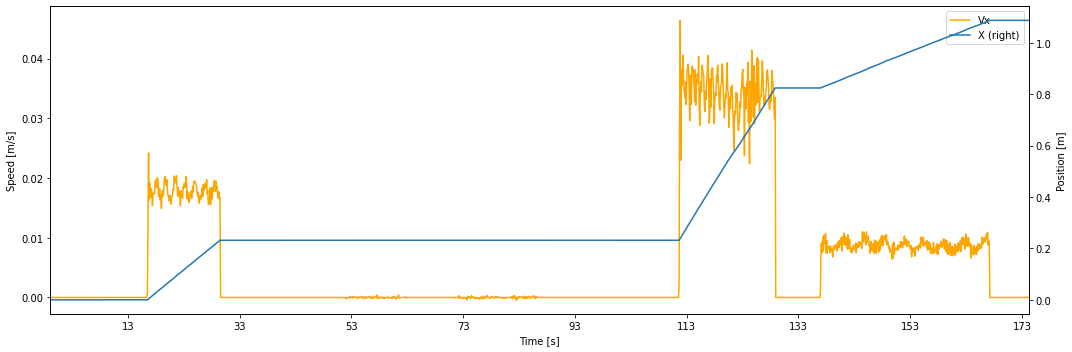

In [8]:
def get_recording_ground_truth(
        recording: Path, force_generation: bool = False
    ) -> pd.DataFrame:
    """Gets the ground truth corresponding to a recording

    Args:
        recording (Path): Path to a recording folder with wheel test bed
            control files, audio files and their corresponding configuration
            files
        force_generation (bool, optional): Force generation instead of loading
            from file. Defaults to False.

    Returns:
        pd.DataFrame: Ground truth of the recording with columns 'X', 'Vx',
        'Vw', 'slip', 'wheel_rotation'
    """
    ground_truth_path = recording / 'ground_truth.csv'
    if not force_generation and ground_truth_path.exists():
        gt = pd.read_csv(ground_truth_path, index_col='timestamp')
    else:
        gt = generate_recording_ground_truth(recording)
        gt.to_csv(ground_truth_path, index_label='timestamp')
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ao.plot.odometry(ground_truth)
ground_truth.head()

### Wheel Odometry

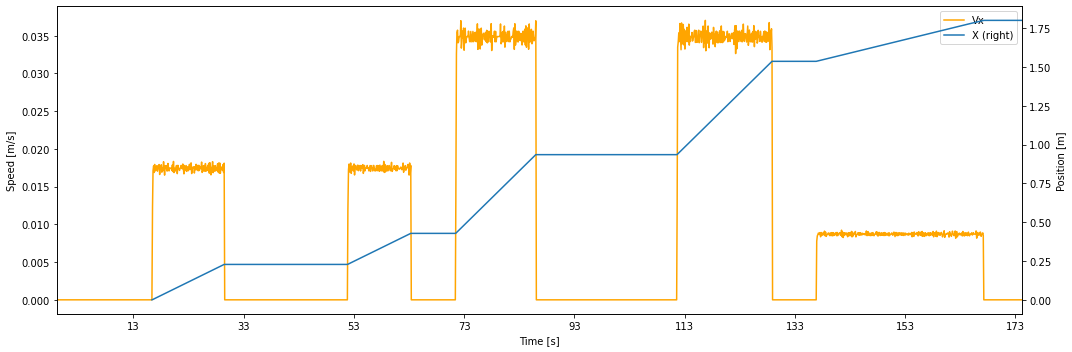

In [9]:
def get_recording_wheel_odometry(
        recording: Path, wheel_radius: float
    ) -> pd.DataFrame:
    return ao.evaluate.generate_wheel_odometry(
        get_recording_ground_truth(recording)['Vw'], wheel_radius=wheel_radius
        )


wheel_odom = get_recording_wheel_odometry(recording, 0.1)
_ = ao.plot.odometry(wheel_odom)

### Visual Odometry

,tx,ty,tz,qx,qy,qz,qw,X,Vx
timestamp,,,,,,,,,
1.653034e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.000000e+00,NaN
1.653034e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,1.0,0.000000e+00,0.000000e+00
1.653034e+09,2.266222e-36,-9.700928e-34,-1.047970e-33,0.0,0.0,0.0,1.0,2.266222e-36,3.425368e-35
1.653034e+09,-1.889253e-36,4.020955e-34,4.165907e-34,0.0,0.0,0.0,1.0,3.769689e-37,-2.806294e-35
1.653034e+09,-1.096647e-36,-1.159546e-34,3.529647e-35,0.0,0.0,0.0,1.0,-7.196782e-37,-3.268832e-35


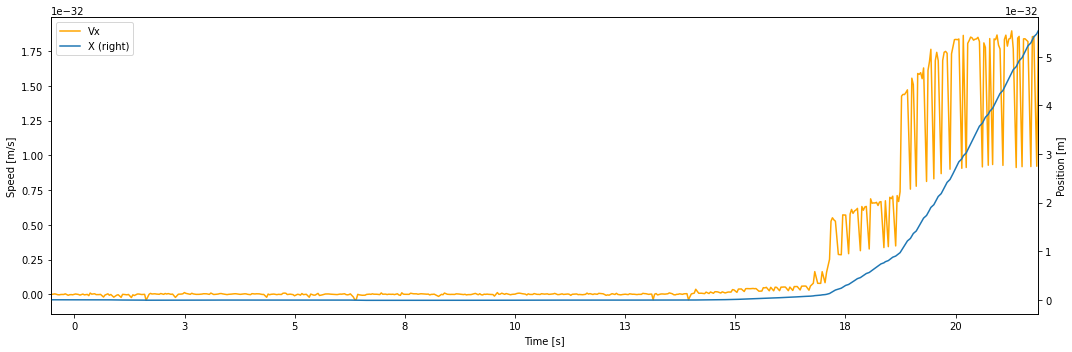

In [10]:
def get_file_visual_odometry(bag_path: Path, method: str) -> pd.DataFrame:
    odometry_path = bag_path.parent / 'VO' / method / bag_path.with_suffix(
        '.txt'
        ).name
    vo = pd.read_csv(
        odometry_path,
        header=None,
        names=['timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'],
        index_col='timestamp',
        sep=' ',
        )
    # TODO need to align it with the ground truth
    vo['tx'] /= 1000  # [mm] -> [m]
    vo['X'] = vo['tx'].cumsum()
    vo['Vx'] = vo['tx'] / vo.index.to_series().diff()
    return vo


def get_recording_visual_odometry(
        recording: Path, method: str
    ) -> pd.DataFrame:
    return get_file_visual_odometry(recording / 'realsense0.bag', method)


visual_odom = get_recording_visual_odometry(recording, method='orbslam2_rgbd')
ao.plot.odometry(visual_odom)
visual_odom.head()

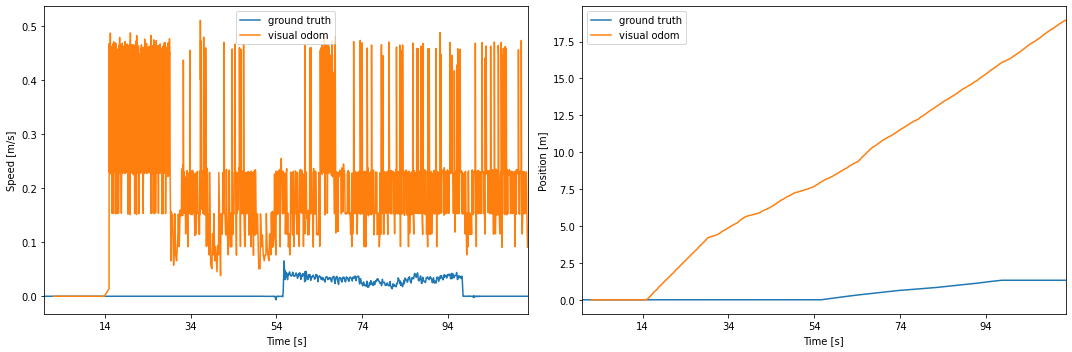

In [11]:
r = EVALUATION_FOLDER / '04_w22'
_ = ao.plot.odometry_comparison([
    (get_recording_ground_truth(r), 'ground truth'),
    (
        get_file_visual_odometry(
            bag_path=r / 'realsense0.bag', method='orbslam2_rgbd'
            ),
        'visual odom',
        ),
    ])

## Generate odometry with model


In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(DEVICE))

Using cuda device


In [13]:
extractors = [
    ao.extractor.GammatoneFilterbank(
        num_samples=int(10 * 44100 / 1000),
        num_features=256,
        sample_rate=44100,
        )
    ]
model = ao.AO(
    model_path=MODELS_FOLDER /
    'torch-script;name_numpy-arrays;date_2022-05-23;time_13-39-14.pt',
    extractors=extractors,
    num_frames=120,
    )

In [14]:
def generate_acoustic_odometry(
    wav_file: Path,
    model: ao.AO,
    pbar: Optional[tqdm] = None,
    *,
    return_config: bool = False,
    ) -> pd.DataFrame:
    """Generates odometry from a wav file using the provided model

    Args:
        wav_file (Path): Audio recording in wav format
        model (ao.AO): Acoustic Odometry model
        pbar (Optional[tqdm]): Progress bar to display. If False, no progress
            bar is displayed.
        return_config (bool, optional): Whether to return the configuration
            dictionary with the odometry data. Defaults to False.

    Returns:
        pd.DataFrame: Odometry data with columns 'Vx', 'tx' and 'X'. If
            `return_config` is True, the configuration dictionary is also
            returned. 
    """
    wav_data, _ = ao.io.wave_read(wav_file)
    config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
    start = config['start_timestamp']
    step = model.num_samples / model.sample_rate
    frames = ao.dataset.audio._frames(
        wav_data.mean(axis=1)[:, np.newaxis], model.num_samples
        )
    timestamps = np.linspace(start, start + len(frames) * step, len(frames))
    Vx = np.zeros(len(frames))
    if pbar is False:
        for i, frame in pbar(enumerate(frames)):
            Vx[i] = model(frame)
    else:
        if pbar is None:
            pbar = tqdm(unit='frames')
        pbar.set_description(f"{wav_file.parent.name}/{wav_file.stem}")
        pbar.reset(total=len(frames))
        for i, frame in enumerate(frames):
            Vx[i] = model(frame)
            pbar.update()
    # Compute X translations and cumulative X position
    Vx = pd.Series(Vx, index=timestamps) / 100  # [cm/s] -> [m/s]
    odom = pd.concat([Vx, Vx.index.to_series().diff() * Vx], axis=1)
    odom.columns = ['Vx', 'tx']
    odom.iloc[0, :] = 0
    odom['X'] = odom['tx'].cumsum()
    if return_config:
        return odom, config
    return odom

,Vx,tx,X
timestamp,,,
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0
1.653034e+09,0.0,0.0,0.0


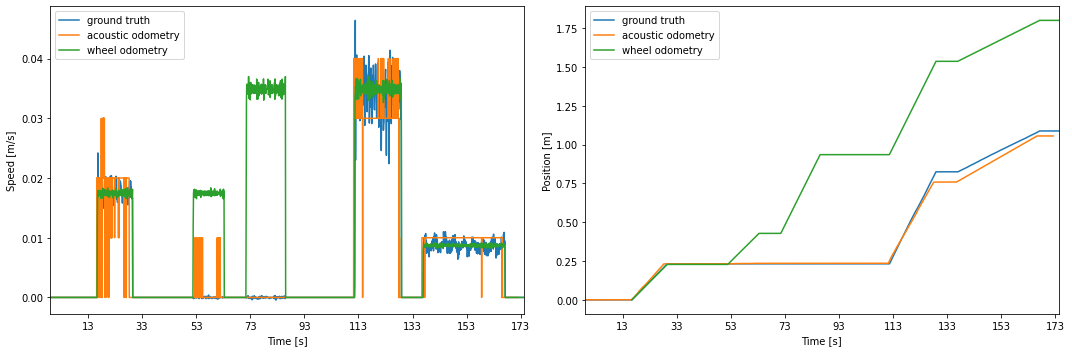

In [15]:
def get_file_acoustic_odometry(
    model: ao.AO,
    wav_file: Path,
    pbar: Optional[tqdm] = None,
    force_generation: bool = False,
    *,
    return_config: bool = False,
    ) -> pd.DataFrame:
    """Gets the odometry data corresponding to a wav file and model

    Args:
        model (ao.AO): Acoustic Odometry model.
        wav_file (Path): Audio recording in wav format.
        pbar (Optional[tqdm]): Progress bar to display. If False, no progress
            bar is displayed.
        force_generation (bool, optional): Force generation instead of loading
            from file. Defaults to False.
        return_config (bool, optional): Whether to return the configuration
            dictionary with the odometry data. Defaults to False.

    Returns:
        pd.DataFrame: Odometry data with columns 'Vx', 'tx' and 'X' and a name
            attribute that corresponds to the stem of the audio file. If
            `return_config` is True, the configuration dictionary is also
            returned. 
    """
    odometry_path = wav_file.parent / 'AO' / str(model) / wav_file.with_suffix(
        '.odometry.csv'
        ).name
    if not force_generation and odometry_path.exists():
        odom = pd.read_csv(odometry_path, index_col='timestamp')
        odom.name = wav_file.stem
        if return_config:
            config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
            return odom, config
        return odom
    odometry_path.parent.mkdir(exist_ok=True)
    odom, config = generate_acoustic_odometry(
        wav_file, model, pbar=pbar, return_config=True
        )
    odom.to_csv(odometry_path, index_label='timestamp')
    odom.name = wav_file.stem
    if return_config:
        return odom, config
    return odom


acoustic_odom = get_file_acoustic_odometry(
    model,
    wav_file=recording / f'microphone0.wav',
    )
ao.plot.odometry_comparison([(ground_truth, 'ground truth'),
                             (acoustic_odom, 'acoustic odometry'),
                             (wheel_odom, 'wheel odometry')])
acoustic_odom.head()

In [16]:
def get_recording_acoustic_odometry(
    model: ao.AO,
    recording: Path,
    pbars: Optional[Dict[str, tqdm]] = None,
    force_generation: bool = False,
    *,
    return_config: bool = False,
    ) -> List[pd.DataFrame]:
    files = sorted(recording.glob('*.wav'))
    result = []
    if pbars is False:
        for wav_file in files:
            result.append(
                get_file_acoustic_odometry(
                    model,
                    wav_file,
                    pbar=False,
                    force_generation=force_generation,
                    return_config=return_config
                    )
                )
        return result
    if not pbars:
        pbars = {
            'files': tqdm(unit='files'),
            'frames': tqdm(unit='frames'),
            }
    pbars['files'].reset(total=len(files))
    for wav_file in files:
        pbars['files'].set_description(wav_file.name)
        result.append(
            get_file_acoustic_odometry(
                model,
                wav_file,
                pbar=pbars['frames'],
                force_generation=force_generation,
                return_config=return_config
                )
            )
        pbars['files'].update()
    return result


0models [00:00, ?models/s]

0files [00:00, ?files/s]

0frames [00:00, ?frames/s]

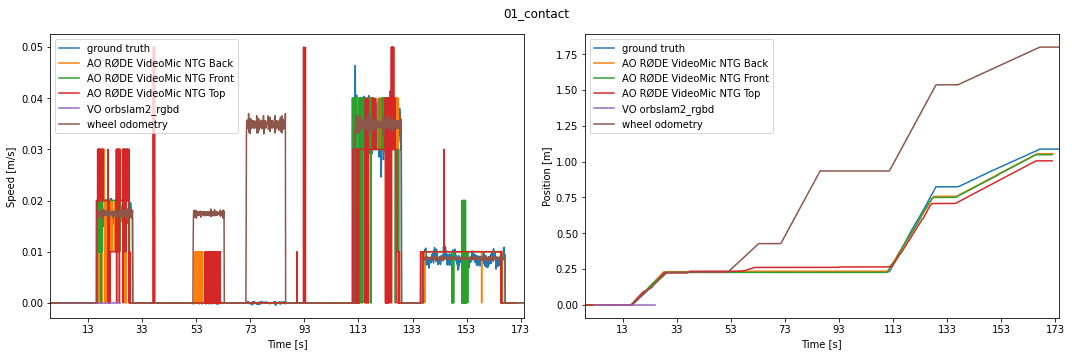

In [17]:
def plot_recording_odometry(
    recording: Path,
    acoustic_odometry_models: List[ao.AO] = [],
    visual_odometry_methods: List[str] = [],
    wheel_odometry_with_radius: Optional[float] = None,
    *,
    acoustic_odometry_device_filter: Callable[
        [str, str], bool] = lambda model, device: True,
    ):
    # Plot ground truth
    ground_truth = get_recording_ground_truth(recording)
    plots = [(ground_truth, 'ground truth')]
    # Plot acoustic odometry
    pbars = {
        'models': tqdm(unit='models'),
        'files': tqdm(unit='files'),
        'frames': tqdm(unit='frames'),
        }
    pbars['models'].reset(total=len(acoustic_odometry_models))
    for model in acoustic_odometry_models:
        pbars['models'].set_description(str(model))
        plots.extend([
            # TODO short model name ?
            (odom, f"AO {config['name']}")
            for odom, config in get_recording_acoustic_odometry(
                model, recording, pbars, return_config=True
                )
            if acoustic_odometry_device_filter(str(model), config['name'])
            ])
        pbars['models'].update()
    # Plot visual odometry
    for method in visual_odometry_methods:
        plots.append(
            (get_recording_visual_odometry(recording, method), f"VO {method}")
            )
    # Plot wheel odometry
    if wheel_odometry_with_radius:
        plots.append((
            get_recording_wheel_odometry(
                recording, wheel_odometry_with_radius
                ), 'wheel odometry'
            ))
    return ao.plot.odometry_comparison(plots, suptitle=recording.name)


_ = plot_recording_odometry(
    recording,
    acoustic_odometry_models=[model],
    acoustic_odometry_device_filter=(
        lambda model, device: 'VideoMic' in device
        ),
    visual_odometry_methods=['orbslam2_rgbd'],
    wheel_odometry_with_radius=0.1
    )


## Evaluate the results


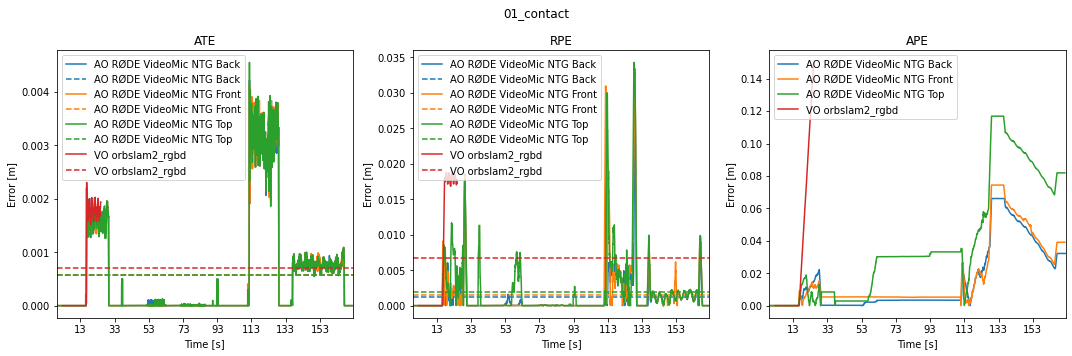

In [18]:
def plot_recording_evaluation(
    recording: Path,
    acoustic_odometry_models: Optional[List[ao.AO]] = None,
    visual_odometry_methods: Optional[List[str]] = None,
    wheel_odometry_with_radius: Optional[float] = None,
    *,
    acoustic_odometry_device_filter: Callable[[str], bool] = lambda d: True,
    axs: Optional[List[plt.Axes]] = None,
    ):
    # Get ground truth
    ground_truth = get_recording_ground_truth(recording)
    plots = []
    # Plot acoustic odometry
    for model in acoustic_odometry_models:
        plots.extend([
            # TODO short model name ?
            (odom, f"AO {config['name']}")
            for odom, config in get_recording_acoustic_odometry(
                model, recording, pbars=False, return_config=True
                )
            if acoustic_odometry_device_filter(str(model), config['name'])
            ])
    # Plot visual odometry
    for method in visual_odometry_methods:
        plots.append(
            (get_recording_visual_odometry(recording, method), f"VO {method}")
            )
    # Plot wheel odometry
    if wheel_odometry_with_radius:
        plots.append((
            get_recording_wheel_odometry(
                recording, wheel_odometry_with_radius
                ), 'wheel odometry'
            ))
    return ao.plot.evaluation_comparison(
        plots, ground_truth, suptitle=recording.name
        )

_ = plot_recording_evaluation(
    recording,
    acoustic_odometry_models=[model],
    acoustic_odometry_device_filter=(
        lambda model, device: 'VideoMic' in device
        ),
    visual_odometry_methods=['orbslam2_rgbd'],
    )

In [19]:
def plot_recordings_evaluation():
    pass

In [20]:
# def evaluate_model(
#     model: ao.AO,
#     recordings: List[Path] = [
#         f for f in EVALUATION_FOLDER.iterdir() if f.is_dir()
#         ],
#     plot_filter: Union[Callable[[str, str], bool],
#                        bool] = lambda recording, name: False,
#     *,
#     evaluate_odometry_kwargs: dict = {'delta_seconds': 2},
#     ) -> pd.DataFrame:
#     # Process input
#     if not isinstance(recordings, list):
#         recordings = [recordings]
#     if not callable(plot_filter):
#         plot_filter = lambda recording, name: plot_filter
#     # Create progress bars
#     progress = {
#         'recordings': tqdm(total=len(recordings), unit='recordings'),
#         'files': tqdm(unit='files'),
#         'frames': tqdm(unit='frames'),
#         }
#     evaluation = pd.DataFrame(columns=['recording', 'device'])
#     for recording in recordings:
#         progress['recordings'].set_description(recording.name)
#         results = _evaluate_model(
#             model,
#             recording,
#             plot_filter,
#             progress,
#             evaluate_odometry_kwargs=evaluate_odometry_kwargs
#             )
#         # Fill evaluation with results metrics
#         for result in results.values():
#             _result = pd.DataFrame.from_records([{
#                 'recording': recording.name,
#                 'device': f"{result['config']['name']}",
#                 **result['metrics']
#                 }])
#             evaluation = pd.concat([evaluation, _result], ignore_index=True)
#         progress['recordings'].update()
#     for pbar in progress.values():
#         pbar.close()
#     evaluation.set_index(['recording', 'device'], inplace=True)
#     # Plot evaluation
#     if plot_filter('', 'evaluation'):
#         columns = [
#             column for column in evaluation.columns
#             if plot_filter('', f"evaluation {column}")
#             ]
#         fig, axs = plt.subplots(len(columns), 1)
#         for ax, column in zip(axs, columns):
#             for recording, results in evaluation[column].groupby('recording'):
#                 r = {
#                     device: v
#                     for (_, device), v in results.to_dict().items()
#                     if plot_filter(recording, f"evaluation {column} {device}")
#                     }
#                 if r:
#                     ax.scatter(r.keys(), r.values(), label=recording)
#             ax.set_title(column)
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#         fig.suptitle(f"model {model}")
#     return evaluation


# evaluation = evaluate_model(
#     model,
#     plot_filter=lambda recording, name: '01' not in recording and 'evaluation'
#     in name and 'smartLav+ top' not in name,
#     )

# Results

In [21]:
def plot_recording(recording):
    _ = plot_recording_evaluation(
        recording,
        acoustic_odometry_models=[model],
        acoustic_odometry_device_filter=(
            lambda model, device: 'VideoMic' in device
            ),
        visual_odometry_methods=['orbslam2_rgbd', 'orbslam2_mono'],
        )


## Contact No-Contact


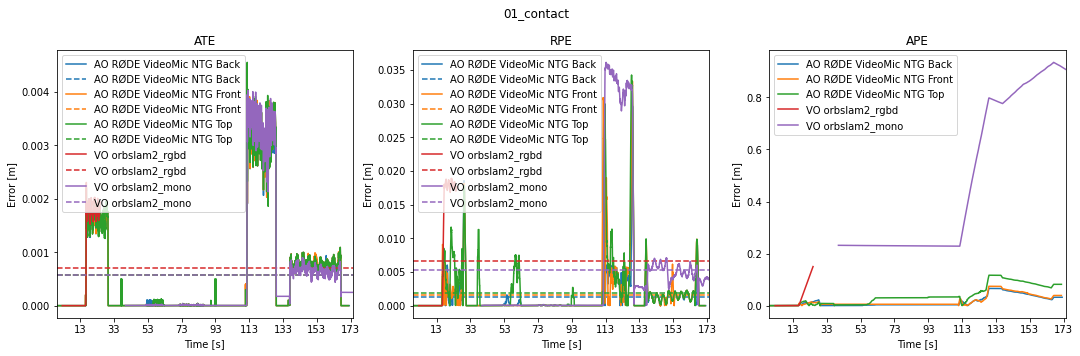

In [22]:
plot_recording(EVALUATION_FOLDER / '01_contact')

## Long


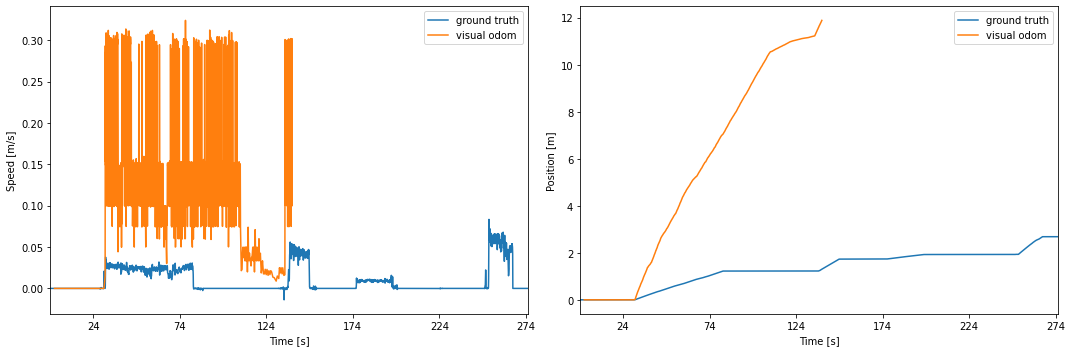

In [23]:
r = EVALUATION_FOLDER / '02_long'
_ = ao.plot.odometry_comparison([
    (get_recording_ground_truth(r), 'ground truth'),
    (
        get_recording_visual_odometry(r, method='orbslam2_rgbd'),
        'visual odom',
        ),
    ])

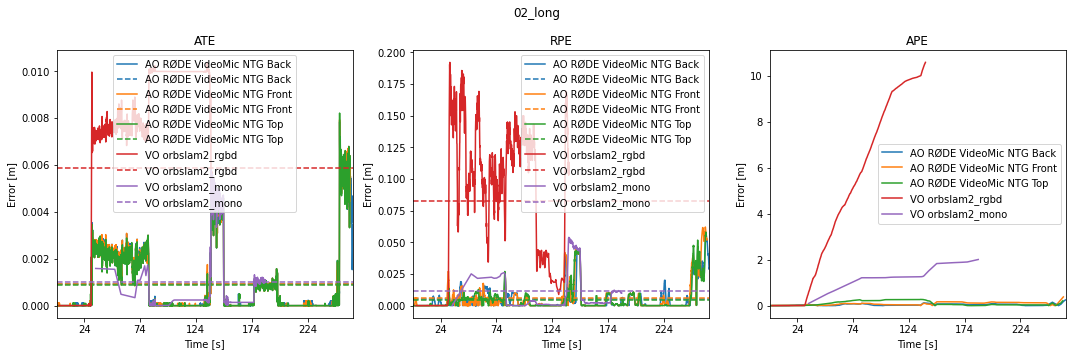

In [24]:
plot_recording(EVALUATION_FOLDER / '02_long')

## Slow slipping


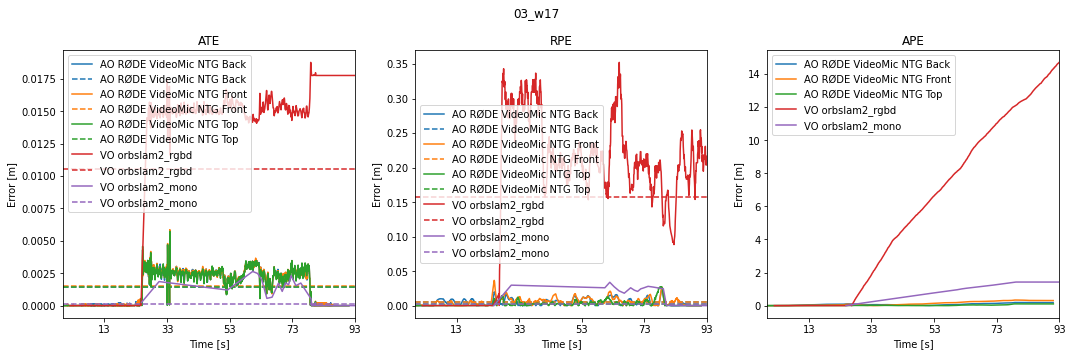

In [25]:
plot_recording(EVALUATION_FOLDER / '03_w17')

## Fast slipping


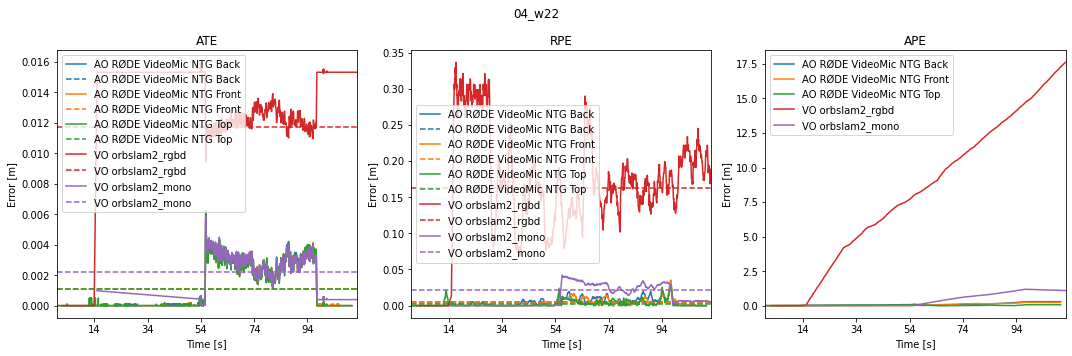

In [26]:
plot_recording(EVALUATION_FOLDER / '04_w22')

## Strong slipping

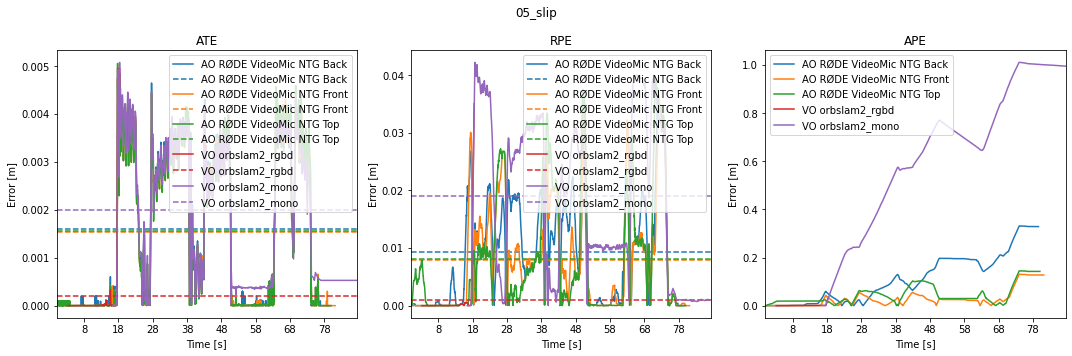

In [27]:
plot_recording(EVALUATION_FOLDER / '05_slip')